In [94]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import Annotated
from operator import add


# Graph state
class State(TypedDict):
    code: str
    description: str
    testcases: str
    reviewed_code:str
    code_approved:str

In [79]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [80]:
llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003684802, 'queue_time': 0.237198962, 'total_time': 0.053684802}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-c93870a4-dde7-4eb7-af4f-600fa55dfce7-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

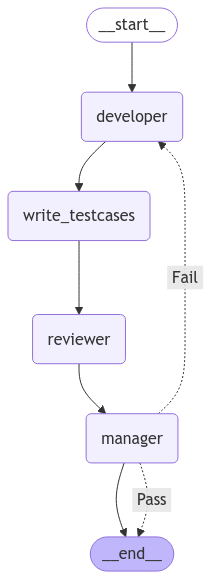

Your code is already quite efficient and clear. However, there are a few tweaks and suggestions to further enhance it, especially in terms of readability and performance:

1. **Use `collections.Counter` for simplicity and efficiency**: If you're open to using built-in facilities, `collections.Counter` can significantly simplify the code.

2. **Filtering and transformation in one pass**: You can use a generator expression to filter and transform the characters in one step, which can make the code more concise.

3. **Error Handling and Documentation**: Adding error handling and documentation can make the function more robust and maintainable.

Here's a revised version of your function incorporating these suggestions:

```python
from collections import Counter

def count_alphabets(input_string):
    """
    Count the frequency of each alphabet in the input string, ignoring case and non-alphabet characters.
    
    :param input_string: The string to be analyzed.
    :return: A dictionary 

In [104]:
# Nodes
def developer(state: State):
    """First LLM call to generate code"""
    msg = llm.invoke(f"Write a code in programming language {state['description']}")
    return {"code": msg.content}

def check_approved(state: State):
    """Gate function to check if the code approved or not"""
    if "approved" in state["code_approved"] or "pass code" in state["code_approved"]:
        return "Pass"
    return "Fail"

# def code_improvements(state:State):
#     """check if there are any improvements suggestions given"""
#     if "improved" in state["reviewed_code"]:
#         return "Fail"
#     return "Pass"

def write_testcases(state: State):
    """llm call to write the test cases for the code"""
    msg = llm.invoke(f"can you please write test cases for the following code: {state['code']}")
    return {"testcases": msg.content}


def reviewer(state: State):
    """Second LLM call to review  the code"""
    msg = llm.invoke(f"Make this code more efficient by giving suggestions with suggestions: {state['code']}")
    print(msg.content)
    return {"reviewed_code": msg.content}


def manager(state: State):
    """Third LLM call for manager review"""
    msg = llm.invoke(f"act like a manager on the code given by reviewer and approves if it looks code good 'Pass' else gives 'Fail': {state['reviewed_code']}")
    return {"code_approved": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("developer", developer)
workflow.add_node("write_testcases", write_testcases)
workflow.add_node("reviewer", reviewer)
workflow.add_node("manager", manager)

# Add edges to connect nodes
workflow.add_edge(START, "developer")
workflow.add_edge("developer", "write_testcases")
workflow.add_edge("write_testcases", "reviewer")
#give suggestions for code improvements
# workflow.add_conditional_edges(
#     "reviewer",code_improvements, {"Fail": "developer", "Pass": "manager"}
# )
workflow.add_conditional_edges(
    "manager",check_approved, {"Fail": "developer", "Pass": END}
)
workflow.add_edge("reviewer", "manager")
workflow.add_edge("manager", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"description": "write a python to read alphabets from a string and store them in dict in with alphabets and its count"})
print("\n--- --- ---\n")
if 'code' in state:
    print(state['code'])
else:
    print("code is not present")
    
if "testcases" in state:
    print(state['testcases'])
    print("\n--- --- ---\n")

    print("Final code:")
else:
    print(" gate - test no code detected!")

if "code_approved" in state:
    print("code_approved.....")
    print(state["code_approved"])